# Mask R-CNN - Train on Deep Vision Dataset

This notebook shows training of the Matterport Mask R-CNN implementation on a Deep Vision dataset annotated with per instance masks of four species (Benthosema, Mackerel, Herring and Blue Whiting).

From the original comments, it is not recommended to run this on a CPU due to the large network backbone based on Resnet-101. 

The full implementation that this is based on can be found here:
https://github.com/matterport/Mask_RCNN

Although the Matterport implementation also includes provision for image augmentation in the included data generator, this was not used. Although this would result in a cleaner overall implementation, the fact of the matter is that considerable work was done on a stand alone image augmentation program before starting the implementation of Mask R-CNN. In summary, this implementation uses pre generated augmented images for the training, validation and testing of the network.


In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
        
# Root directory of the project
ROOT_DIR = os.path.abspath("../Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [5]:
class FishConfig(Config):
    """Configuration for training on the fish dataset.
    Derives from the base Config class and overrides values specific
    to the fish dataset.
    """
    # Give the configuration a recognizable name
    NAME = "fish"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 # was 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 3 species

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (32, 64, 128,256,512)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128 #was 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 2500 #was 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50 # was 5
    
config = FishConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the fish dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [7]:
from PIL import Image
import pandas as pd

class FishDataset(utils.Dataset):
    """Loads data for the fish dataset.
    """
    
    def __init__(self, mask_dir):
        self._image_ids = []
        self.image_info = []
        # Background is always the first class
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]
        self.source_class_ids = {}
        self.mask_dir = mask_dir            

    def load_fish(self, count, fish_dir):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes      
        self.add_class("fish", 1, "Benthosema")
        self.add_class("fish", 2, "BlueWhiting")
        self.add_class("fish", 3, "Herring")
        self.add_class("fish", 4, "Mackerel")
        
        imgs = os.listdir(fish_dir)
        for f in imgs[:]: # filelist[:] makes a copy of filelist.
            if not(f.endswith(".png") or f.endswith(".jpg")):
                imgs.remove(f)
        use_imgs = np.random.choice(imgs, count)
        for i in use_imgs:
            
            self.add_image("fish", image_id=i, path=fish_dir+'/'+i)   

    def load_image(self, image_id):
        """
        Load an image
        """
        image = Image.open(self.image_info[image_id]['path'])
        
        return np.asarray(image).astype(np.uint8)

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """
        Load masks from files corresponding to image_id
        """
        
        info = self.image_info[image_id]                
        csv_id = info['id'][:-4] + '.csv'
        mask_dir = self.mask_dir
        instance_list = pd.read_csv(os.path.join(mask_dir, csv_id), header=None)                
               
        class_ids = np.asarray(instance_list[1])
        mask_names = np.asarray(instance_list[0])
        
        #print(instance_list)
        nmask = len(class_ids)                
        masks = np.empty([config.IMAGE_SHAPE[0],config.IMAGE_SHAPE[1],nmask])
        for i in range(0, nmask):
            mask_id = info['id'][:-4] + '-' + str(i) + '.png'
            masks [:,:,i] =  Image.open(os.path.join(mask_dir, mask_id))
        
        
        unique_class_ids = np.unique(class_ids)
        #print('unique ids' + str(unique_class_ids))
        
        mask_area = [np.sum(masks[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
        #print(mask_area)
        
        # need to reorder classes according to size of mask area.
        # this is due to the visualization sorting this way
        # so we build a new stack of masks sorted by dominance
        # length will be the same though            
        
        # get order from mask_area
        order_of_args = np.argsort(mask_area)[::-1].tolist()
        
        sorted_unique = np.copy(unique_class_ids)
        for i,pos in enumerate(order_of_args):
            sorted_unique[i] = unique_class_ids[pos]
        
        # sort class ids from this        
        sorted_class_ids = np.asarray(sorted(class_ids.tolist(),key=sorted_unique.tolist().index))
        
        # build new masks using this order.
        new_masks = np.empty([config.IMAGE_SHAPE[0],config.IMAGE_SHAPE[1],nmask])
        
        j = 0
        for uid in sorted_unique:
            for i in range(0, nmask):
                if class_ids[i] == uid:
                    mask_id = info['id'][:-4] + '-' + str(i) + '.png'
                    #print(mask_id,j, dataset_train.class_names[uid+1])
                    new_masks [:,:,j] =  Image.open(os.path.join(mask_dir, mask_id))
                    j = j+1

        sorted_class_ids = np.add(sorted_class_ids, 1)                                   
        
        return new_masks.astype(np.bool), sorted_class_ids.astype(np.int32)          

In [8]:
# Training dataset
dataset_train = FishDataset('mask_out')
dataset_train.load_fish(10000, 'images_out')
dataset_train.prepare()

In [9]:
# Validation dataset
dataset_val = FishDataset('val_mask')
dataset_val.load_fish(1000, 'val_img')
dataset_val.prepare()

In [10]:
# Test dataset
dataset_test = FishDataset('test_mask')
dataset_test.load_fish(1000, 'test_img')
dataset_test.prepare()

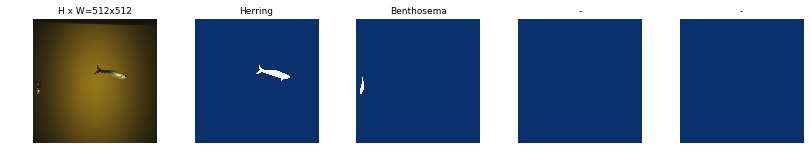

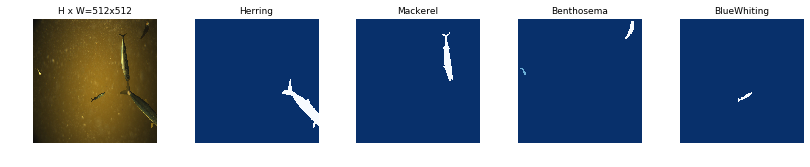

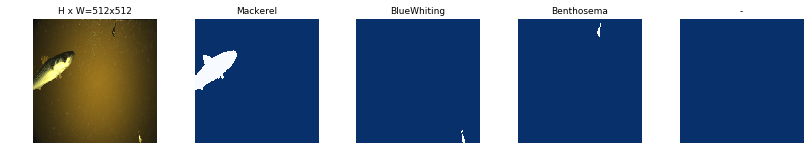

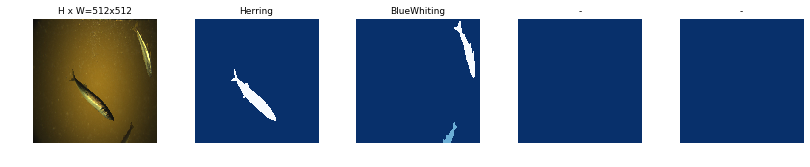

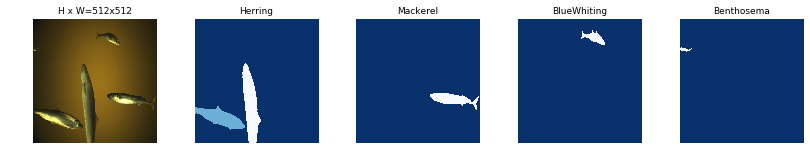

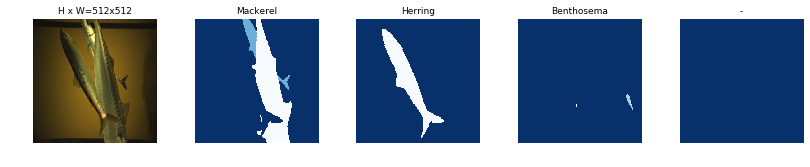

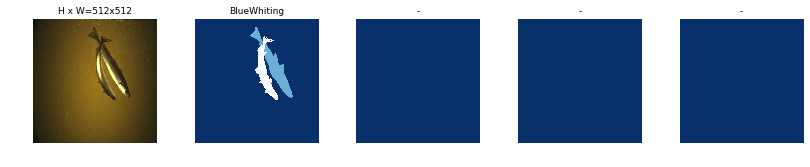

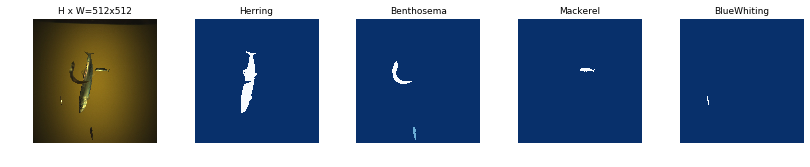

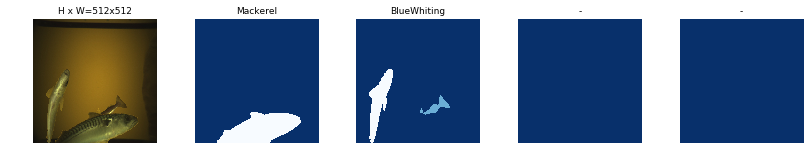

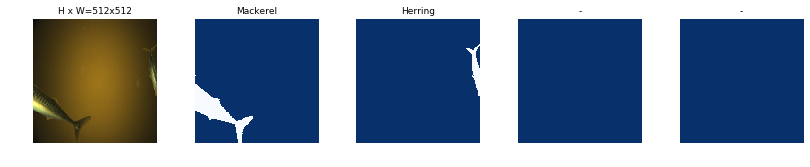

In [8]:
# Load and display random samples
from IPython.display import display
image_ids = np.random.choice(dataset_train.image_ids, 10)

for image_id in image_ids:
    image = dataset_train.load_image(image_id)    
    mask, class_ids = dataset_train.load_mask(image_id)    
    visualize.display_top_masks(np.array(image), mask, class_ids, dataset_train.class_names)       

## Create Model

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 6


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [11]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=3, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/hvagstol/code_repo/Mask_RCNN/logs/fish20190405T0656/mask_rcnn_fish_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
m

/home/hvagstol/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/3
2500/2500 [==============================] - 1824s 730ms/step - loss: 1.0696 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.4397 - mrcnn_class_loss: 0.2836 - mrcnn_bbox_loss: 0.1672 - mrcnn_mask_loss: 0.1379 - val_loss: 0.8678 - val_rpn_class_loss: 0.0260 - val_rpn_bbox_loss: 0.3622 - val_mrcnn_class_loss: 0.2141 - val_mrcnn_bbox_loss: 0.1307 - val_mrcnn_mask_loss: 0.1348
Epoch 2/3
2500/2500 [==============================] - 1769s 708ms/step - loss: 0.8910 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.4086 - mrcnn_class_loss: 0.2150 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.1173 - val_loss: 1.3885 - val_rpn_class_loss: 0.0743 - val_rpn_bbox_loss: 0.9014 - val_mrcnn_class_loss: 0.1975 - val_mrcnn_bbox_loss: 0.1084 - val_mrcnn_mask_loss: 0.1069
Epoch 3/3
2500/2500 [==============================] - 1798s 719ms/step - loss: 0.8100 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.3899 - mrcnn_class_loss: 0.1769 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.1108 - val_loss: 0.7258 - 

In [12]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=6, 
            layers="all")


Starting at epoch 3. LR=0.0001

Checkpoint Path: /home/hvagstol/code_repo/Mask_RCNN/logs/fish20190405T0656/mask_rcnn_fish_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(FishConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /home/hvagstol/code_repo/Mask_RCNN/logs/fish20190405T0656/mask_rcnn_fish_0006.h5
Re-starting from epoch 6


original_image           shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max:  957.00000  int64
gt_class_id              shape: (4,)                  min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (4, 4)                min:    9.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 4)         min:    0.00000  max:    1.00000  bool


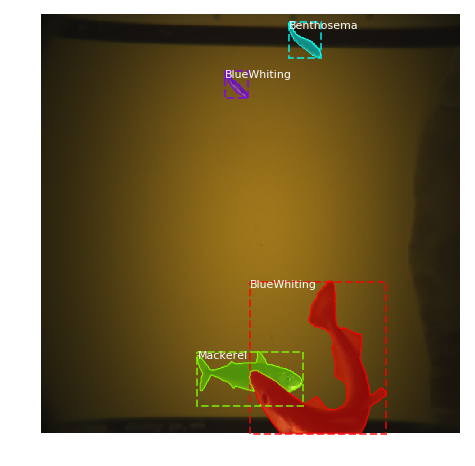

In [12]:
# Test on a random image
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  138.20000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


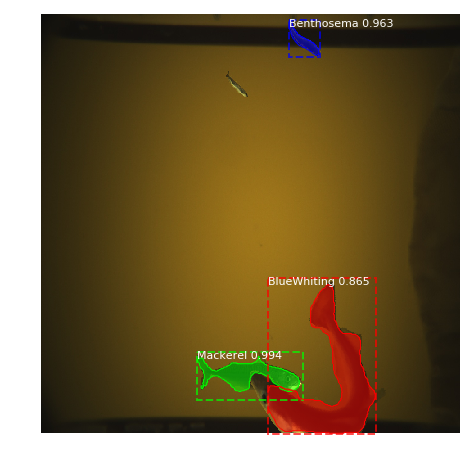

In [14]:
results = model.detect([original_image], verbose=1)


r = results[0]


visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_test.class_names, r['scores'], ax=get_ax())


Processing 1 images
image                    shape: (1040, 1392, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1392.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


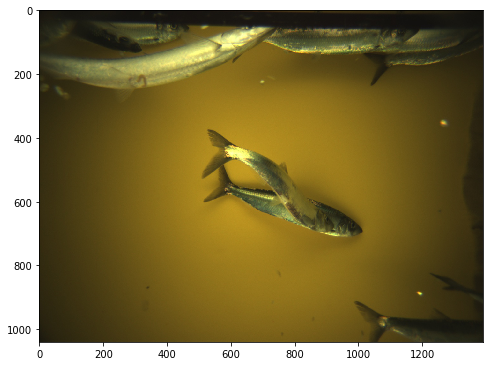

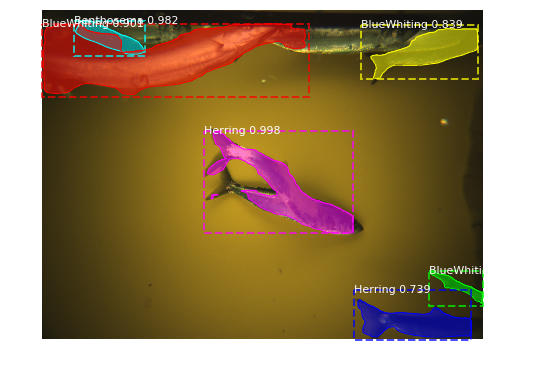

In [24]:
from IPython.display import display
# Real dataset
dataset_real = FishDataset('')
dataset_real.load_fish(84, 'real_data')#, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_real.prepare()

image_id = np.random.choice(dataset_real.image_ids)
original_image = dataset_real.load_image(image_id)
results = model.detect([original_image], verbose=1)
plt.figure(figsize=(8.4,6.1))
plt.imshow(original_image)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_test.class_names, r['scores'], ax=get_ax())


In [17]:
def get_conf(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0):
    """ Get lists of ground truth labels matched with predicted labels.

    Returns:
        gt_labels: list of ground truth labels for each instance
        pred_class: list of corresponding predictions        
    """

    # Trim zero padding
    # TODO: cleaner to do zero unpadding upstream
    gt_boxes = utils.trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
                        
    pred_boxes = utils.trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    # Sort predictions by score from high to low
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]

    # Compute IoU overlaps [pred_masks, gt_masks]    
    overlaps = utils.compute_overlaps_masks(pred_masks, gt_masks)

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    gt_labels = []
    pred_labels = []
    
    # TODO: handle cases where n gt_boxes != n pred_boxes
    
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]        
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            
            # If ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
             # we use the best match for each mask here
            gt_label = gt_class_ids[j]
            pred_label = pred_class_ids[i]
            gt_labels.append(gt_label) 
            pred_labels.append(pred_label)
            if (gt_label == pred_label):                            
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j            

    return gt_labels, pred_labels

## Evaluation

In [18]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_test.image_ids, 1000)

# run entire test set at some point
#image_ids = dataset_test.image_ids
APs = []

y_true = []
y_pred = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    gt_labels, pred_labels = get_conf(gt_bbox, gt_class_id, gt_mask, r['rois'],r['class_ids'],r['scores'],r['masks'])
    y_true = y_true + gt_labels
    y_pred = y_pred + pred_labels

    
print("mAP: ", np.mean(APs))


mAP:  0.8701267880306712


0.9182430266110932
             precision    recall  f1-score   support

          1       0.96      0.98      0.97       728
          2       0.91      0.85      0.88       714
          3       0.84      0.93      0.88       833
          4       0.97      0.91      0.94       844

avg / total       0.92      0.92      0.92      3119



Text(91.68, 0.5, 'predicted label')

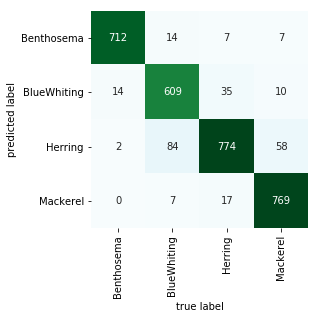

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(y_true, y_pred)
print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))


sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn',
            xticklabels=dataset_test.class_names[1:], yticklabels=dataset_test.class_names[1:])
plt.xlabel('true label')
plt.ylabel('predicted label')